# Making that 2D plot

This notebook explains and takes one through the process of developing an efficiency map.

What is that? 

Well, for usage with our power cutting method, for an ensemble of events we can look at the relationship between pitch angle and radial magnitude away from the on-axis position. 

Looking at this, we can generate a 2D map of the efficiency of the power cutting method with x-axis being the pitch angle and y-axis being the radial magnitude.

In [2]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *
from analysis import *

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

R, Nch, kb, bw, Nsamp, T= 496.1709043911709, 1, 1.38e-23, 1000e6, 40960, 5

n_pwr = kb * T * bw # noise power
tau_1t = n_pwr * R # noise variance single channel, time-domain (tau_1t)
tau_1f = tau_1t / Nsamp # noise variance single channel, freq-domain (tau_1f)

# Generate example distributions
def calculate_signal_dists(vals, tau, loc, FFT_peaks, Nsamp):

    rice_cdf = np.ones(len(vals))
    for peak in FFT_peaks:
        rice_cdf *= scipy.stats.rice.cdf(vals, b=abs(peak)/np.sqrt(tau/2), loc=loc, scale=np.sqrt(tau/2))
            
    cdf = rice_cdf * (1-np.exp(-(vals**2)/tau)) ** (Nsamp-FFT_peaks.size)

    pdf = np.gradient(cdf, vals[1]-vals[0])
    
    return cdf, pdf
    
def calculate_noise_dists(vals, tau, Nsamp):
    ray_cdf = (1-np.exp(-(vals**2)/tau)) ** Nsamp
    ray_pdf = np.gradient(ray_cdf, vals[1]-vals[0])
    
    return ray_cdf, ray_pdf



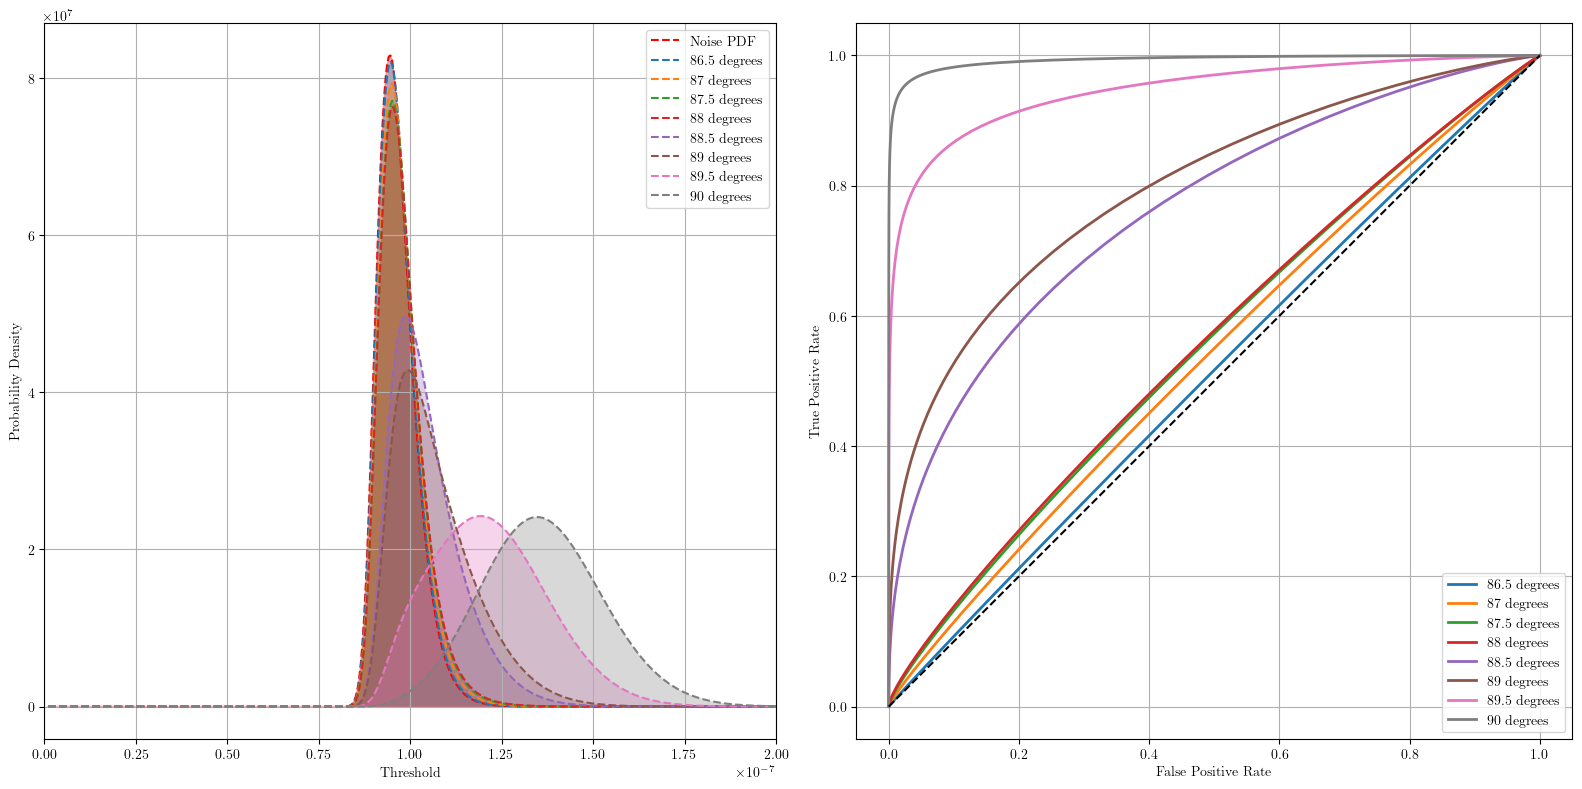

In [3]:
from scipy import stats

threshold = np.linspace(1e-9, 9e-6, 20001)
x = threshold

noise_pdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[1]
# signal_pdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[1]
# signal86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[1]

# Calculate CDFs
noise_cdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[0]
# signal_cdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[0]
# signal_cdf86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[0]

# Calculate ROC points (FPR = 1-specificity, TPR = sensitivity)
fpr = 1 - noise_cdf  # false positive rate


file_list = [
    'harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5', 
    'harmonic/87deg/out_0a5c4e19-2fc3-4f5c-9090-8d2cce62ae19.h5', 
    'harmonic/87p5deg/out_0c7fdf39-0ea3-4c84-9a9d-60c68b480bb1.h5', 
    'harmonic/88deg/out_0ad74f8f-ec02-44f5-a5af-5c69bef4774e.h5',
    'harmonic/88p5deg/out_0a1bc7f8-6e25-47f3-9743-f404227c3d0b.h5',
    'harmonic/89deg/out_1a0ad631-1153-47ef-8cba-ea9ab0cefa3d.h5',
    'harmonic/89p5deg/out_51db499d-c8ea-4cce-884b-d9c3e3f44ed1.h5',
    'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5']

harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89','89.5', '90']

# Plot distributions and ROC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot PDFs
ax1.plot(threshold, noise_pdf, 'r--', label='Noise PDF')
ax1.fill_between(threshold, noise_pdf, alpha=0.3, color='red')

aucs = []

for i, file_name in enumerate(file_list):

    # signal_strings, attributes, attrs_container = get_attributes(file_name)
    signal = get_signal(file_name, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    # signal_maximums = signal_FFT[signal_FFT > 1e-8]
    # peaks = np.array(signal_maximums)
    
    # print(peaks)
    
    # signal_max_index = np.argmax(abs(signal_FFT))
    # complex_signal_max = signal_FFT[signal_max_index]

    pks = get_signal_peaks(signal, 1e-8)
    
    # print(peaks)

    rice_cdf = np.ones(20001)
    for peak in pks:
        rice_cdf *= scipy.stats.rice.cdf(x, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
        
    signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)

    signal_pdf = np.gradient(signal_cdf, x[1]-x[0])


    tpr = 1 - signal_cdf  # true positive rate

    signal_label = str(harmonic_angles[i]) + ' degrees'
    
    ax1.plot(threshold, signal_pdf, '--', label=signal_label)
    ax1.fill_between(threshold, signal_pdf, alpha=0.3)
    # Plot ROC curve
    
    roc_label = str(harmonic_angles[i]) + ' degrees'
    
    ax2.plot(fpr, tpr, '-', linewidth=2, label=roc_label) 
    auc = abs(np.trapz(tpr, fpr))
    aucs.append(auc)


ax1.set_xlabel('Threshold')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.set_xlim(0, 0.2e-6)
ax1.grid(True)


ax2.plot([0, 1], [0, 1], 'k--')  # random guess line
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.grid(True)
ax2.set_aspect('equal')
ax2.legend()

plt.tight_layout()
plt.savefig('harmonic_roc.png')
plt.show()

In [5]:
path_to_dir = '/Users/nathan/Desktop/BatchCreatedFiles/Harmonic/' # Path to data

# create a list of all the .h5 files in all the subdirectories
file_list = []
for root, dirs, files in os.walk(path_to_dir):
    for file in files:
        if file.endswith('.h5'):
            file_list.append(os.path.join(root, file))
        
print(len(file_list))

3713
